# Yelp Marketing Analysis Report

<li>
<a href = '#Geo-Plots'>Geo-Plots</a>
</li>
<li>
<a href = '#Line-Chart'>Line-Chart</a>
</li>

<li>
<a href = '#Word-Cloud'>Word-Cloud</a>
</li>
<li>
<a href = '#Seaborn'>Seaborn Plots</a>
</li>


<li>
<a href = '#covid'>Business response to covid</a>
</li>
<li>
<a href = '#graph'>Four D Graph</a>
</li>

<li>
<a href = '#pie'>Pie Chart</a>
</li>

In [144]:
#importing necessary libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

import geoplotlib
from geoplotlib.utils import read_csv
from geoplotlib.utils import DataAccessObject
                                                                                                                                                        

import plotly.express as px
from ipywidgets import interact

import altair as alt

from math import pi

from bokeh.io import push_notebook, show, output_notebook
from bokeh.palettes import Category20c
from bokeh.layouts import row 
from bokeh.plotting import figure
from bokeh.transform import cumsum

from wordcloud import WordCloud, STOPWORDS 

output_notebook()

Loading BokehJS ...

In [2]:
# reading business dataset
business = pd.read_json("/home/jasp/sem_3/cpsc/project/yelp_dataset/data/yelp_academic_dataset_business.json", lines=True)

# 1 Geo-plots
<a id = 'Geo-Plots'></a>

### 1.1 Bubble Plot 

In [3]:
# Data Wrangling for Geo Bubble Plot
mydata_bubble = pd.DataFrame(business['review_count'].groupby([business['state'],business['name']]).sum()).reset_index()


# adding tool tips for better presentation
mapping = {
           'AZ':'Arizona,US' ,
           'NV':'Nevada,US',
           'ON':'Ontario, CA',
           'OH':'Ohio, US',
           'NC':'North Carolina, US',
           'PA':'Pennsylvania, US',
           'QC':'Quebec, CA',
           'AB':'Alberta, CA',
           'WI':'Wisconsin, US',
           'IL':'Illinois, US'
          }

mydata_bubble['state_name'] = mydata_bubble['state'].map(mapping)

In [4]:
def geo_function(business_name):
    fig = px.scatter_geo(mydata_bubble[mydata_bubble['name'].str.match(business_name)],
    locations="state", # name of column which contains state codes
    size="review_count", # name of column which contains aggregate value to visualize
    locationmode = 'USA-states',
    hover_name="state_name",
    size_max=45)
    fig.update_layout(
    # add a title text for the plot
    title_text = 'Yelp, US ',
    geo_scope='usa',
    width=760
    )
    
    return fig.show()


In [5]:
options=[('Starbucks','Starbucks'),('McDonald','McDonald'),('Subway','Subway'),('Tim Hortons','Tim'),('Burger King','Burger King')]
interact(geo_function, business_name=options)

interactive(children=(Dropdown(description='business_name', options=(('Starbucks', 'Starbucks'), ('McDonald', …

<function __main__.geo_function(business_name)>

## 2 Choropleth

In [7]:
# Data Wrangling for Choropleth
df_for_business_count = pd.DataFrame(business['business_id'].groupby(business['state']).count()).reset_index()


In [8]:
import plotly.graph_objects as go


fig = go.Figure(data=go.Choropleth(
    locations=df_for_business_count['state'], # Spatial coordinates
    z = df_for_business_count['business_id'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'YlGnBu',
    colorbar_title = "Total Business Registered",
))

fig.update_layout(
    title_text = 'Businesses Registered on Yelp by State',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

#  2 Analysing Review Count

<a id='Line-Chart'></a>

## 2.1 Line Chart

In [11]:
#loading reviews data
review_updated = pd.read_csv('/home/jasp/sem_3/cpsc/project/yelp_dataset/code/reviews_updated.csv',
                             usecols = lambda column : column not in ["Unnamed: 0" ])

In [12]:
# Data Wrangling
review_updated['date'] = pd.to_datetime(review_updated['date'])
review_updated['year'] = review_updated.date.dt.year

In [13]:
# merge reviews and business 

merged_reviews_business_data = review_updated.merge(business,left_on='business_id',right_on='business_id')

In [14]:
merged_reviews_business_data = merged_reviews_business_data[['year','business_id','name']]

In [15]:
final_data_line_plot = pd.DataFrame(merged_reviews_business_data['business_id'].groupby([merged_reviews_business_data.year,merged_reviews_business_data.name]).count()).reset_index()

In [24]:
final_data_line_plot.head()

,year,name,business_id
0,2004,Bellagio Hotel,1
1,2004,Body English,1
2,2004,Gumby's Pizza,1
3,2004,"Holley M Heyert, DC",1
4,2004,Jimmy John's,1


In [25]:
input_data_line_chart = final_data_line_plot[final_data_line_plot['name'].isin(['Burger King','Tim Hortons','Starbucks','Subway'])]

In [26]:
input_data_line_chart.head()

,year,name,business_id
494,2005,Starbucks,1
2293,2006,Starbucks,8
3483,2007,Burger King,3
7524,2007,Starbucks,26
7596,2007,Subway,1


In [170]:
input_dropdown = alt.binding_select(options=list(set(input_data_line_chart.name.unique())))

selected_points = alt.selection_single(fields=['name'], bind=input_dropdown, name='Select')

color = alt.condition(selected_points,alt.Color('name:N'),alt.value('lightgrey'),legend=alt.Legend(title="Businesses"))

alt.Chart(input_data_line_chart).mark_line().encode(
    x=alt.X('year:Q', axis=alt.Axis( title='Year')),
    y=alt.X('business_id:Q', axis=alt.Axis(title='Review Count')),
    color=color,
    tooltip='name:Q').add_selection(selected_points)


alt.Chart(...)

## 2.2 Interactive Bar Chart

In [169]:



fig = px.bar(input_data_line_chart, 
             x="name", 
             y="business_id", 
             color="name",
             range_y=[0,35000],
             title="Total Reviews wrt Businesses",
             labels={
                     "name": "Business",
                     "business_id": "Review Count"
                 }
             )
fig.show()

# 3 Interactive Word Cloud
<a id ='Word-Cloud'></a>

In [32]:
from ipywidgets import interact
def my_function(Rating):


    # trying to have dropdown for wordcloud

    temp_categories = business.categories[business.stars ==Rating]
    temp_categories.dropna(inplace=True)

    Categories={}
    for i in temp_categories:
        all_categories=i.split(",")
        for cat in all_categories:
            if cat not in Categories:
                Categories[cat]=1
            else:
                Categories[cat]+=1



    from wordcloud import WordCloud

    wordcloud = WordCloud(background_color='white',
                          width=1500,
                          height=1000,
                          max_words=200
                          ).generate_from_frequencies(Categories)
    # use .generate(space_separated_string) - to generate cloud from text

    plt.figure(figsize=(9,6))
    #plt.imshow(wordcloud)
    #plt.axis('off')
    #plt.imshow(wordcloud)
    #plt.figure()
    #plt.imshow(alice_mask)





    # show
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.figure()
    plt.axis("off")
    plt.show()


In [35]:

options=[('One', 1), ('Two', 2), ('Three', 3),('Four',4),('Five',5)]
interact(my_function, Rating=options)

interactive(children=(Dropdown(description='Rating', options=(('One', 1), ('Two', 2), ('Three', 3), ('Four', 4…

<function __main__.my_function(Rating)>

In [147]:
df2 = pd.read_json("/home/jasp/sem_3/cpsc/project/yelp_dataset/data/yelp_academic_dataset_tip.json", lines=True)

In [150]:
text = " ".join(review for review in df2.text)

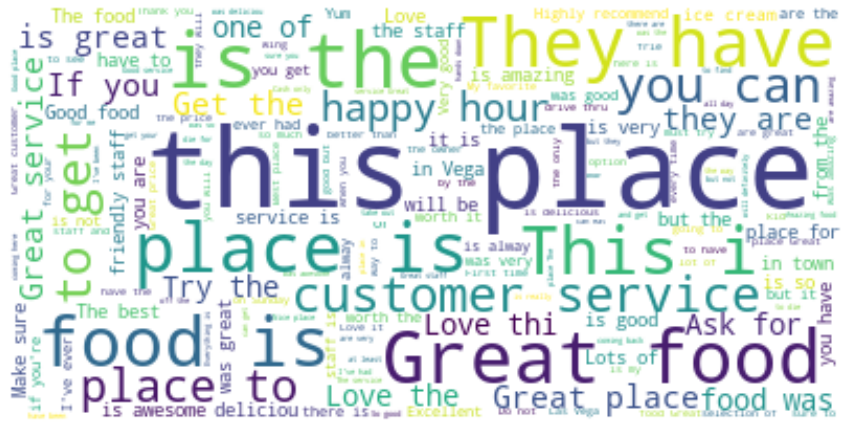

In [151]:
fig=plt.figure(figsize=(15,8))
wordcloud = WordCloud(stopwords=df2['text'], background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# 4 Seaborn plots

<a id ="Seaborn"></a>

## 4.1 province wise analysis

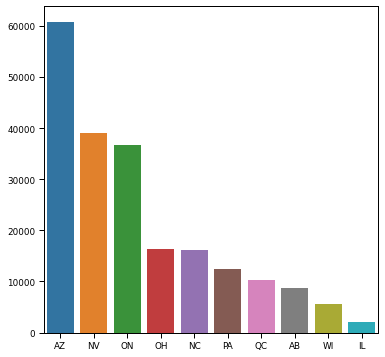

In [38]:
sns.set_context('paper')

f, ax = plt.subplots(figsize = (6,6))
sns.barplot(x = business.state.value_counts().head(10).index, 
            y = business.state.value_counts().head(10).values, 
            data = business)
plt.show()

## 4.2 city wise analysis

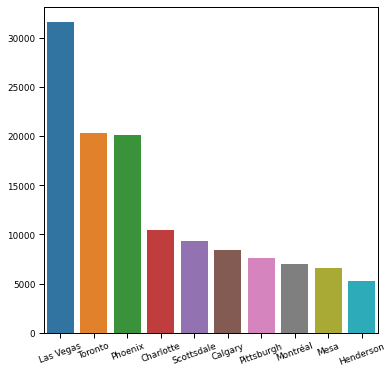

In [39]:
sns.set_context('paper')

f, ax = plt.subplots(figsize = (6,6))
sns.barplot(x = business.city.value_counts().head(10).index, 
            y = business.city.value_counts().head(10).values, 
            data = business)

plt.xticks(rotation=20)
plt.show()

## 4.3 Distribution of Star Ratings vs the status of the business

In [131]:
user = pd.read_csv('/home/jasp/sem_3/cpsc/project/yelp_dataset/data/user_csv',nrows=4000)

In [132]:
user['elite_bool'] = np.where(user.elite.isnull(), 0, 1)  

(0.0, 6.0)

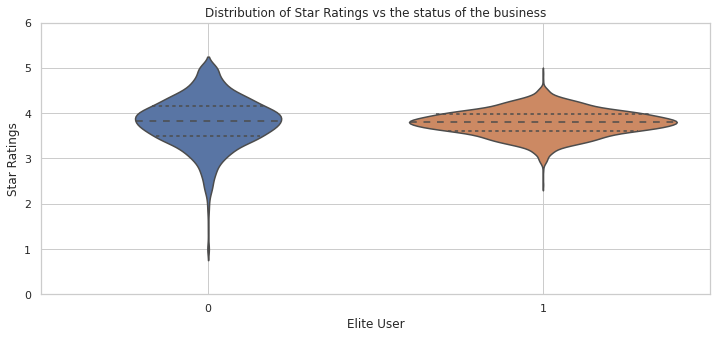

In [133]:
#violin plot for star rating for elite vs non-elite users
sns.set(font_scale = 1)
sns.set_context({"figure.figsize": (12, 5)})
sns.set_style("whitegrid")

g = sns.violinplot(x='elite_bool',y = 'average_stars', data = user,inner="quart")

plt.title("Distribution of Star Ratings vs the status of the business")
plt.xlabel('Elite User')
plt.ylabel('Star Ratings')
g.axes.grid('off')
plt.ylim(0, 6)

## 4.4 Review Count by eliteness of the user

Text(0.5, 1.0, 'Review Count by eliteness of the user')

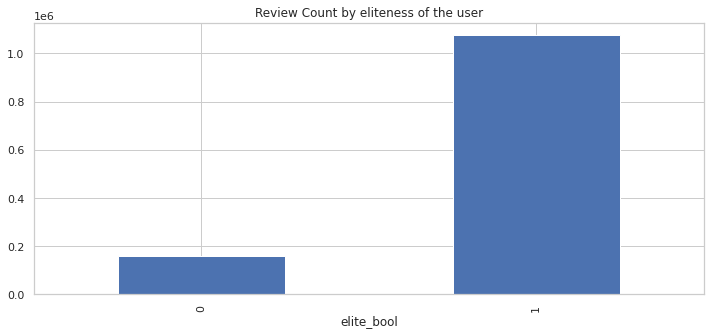

In [134]:
sns.set_context({"figure.figsize": (12, 5)})
df = user.groupby('elite_bool')
df.review_count.sum().plot(kind = 'bar')
plt.title('Review Count by eliteness of the user')

## 4.5 Check in Time

In [136]:
check_in = pd.read_json("/home/jasp/sem_3/cpsc/project/yelp_dataset/data/yelp_academic_dataset_checkin.json", lines=True)

In [137]:
#monday =0 sunday = 6
weekdays =[]
for x in check_in.head().date:
    all_dates=x.split(",")
    for dates in all_dates:
        weekdays.append(pd.to_datetime(dates).weekday())
        

        
Monday = 0 
Tuesday =0
Wednesday =0
Thrusday =0
Friday =0
Saturday =0
Sunday =0

for day_of_week in weekdays:
    if day_of_week == 0:
        Monday=Monday+1
    elif day_of_week ==1:
        Tuesday = Tuesday +1
    elif day_of_week ==2:
        Wednesday = Wednesday +1
    elif day_of_week == 3:
        Thrusday = Thrusday +1
    elif day_of_week == 4:
        Friday = Friday +1
    elif day_of_week == 5:
        Saturday = Saturday +1
    elif day_of_week == 6:
        Sunday =Sunday+1
        
source = pd.DataFrame({'Day': ['Monday', 'Tuesday', 'Wednesday', 'Thrusday', 'Friday','Saturday','Sunday'],
                           'Count': [Monday, Tuesday, Wednesday, Thrusday, Friday,Saturday,Sunday]})

In [138]:
alt.Chart(source).transform_joinaggregate(
    TotalTime='sum(Count)',
).transform_calculate(
    PercentOfTotal="datum.Count / datum.TotalTime"
).mark_bar().encode(
    alt.X('PercentOfTotal:Q', axis=alt.Axis(format='.0%')),
    y='Day:N'
).interactive()

alt.Chart(...)

In [141]:
a1 = np.asarray(business.groupby(['state']).mean()['stars'])
d=pd.DataFrame({'State':business['state'].unique(),'Stars':a1})

<Figure size 864x360 with 0 Axes>

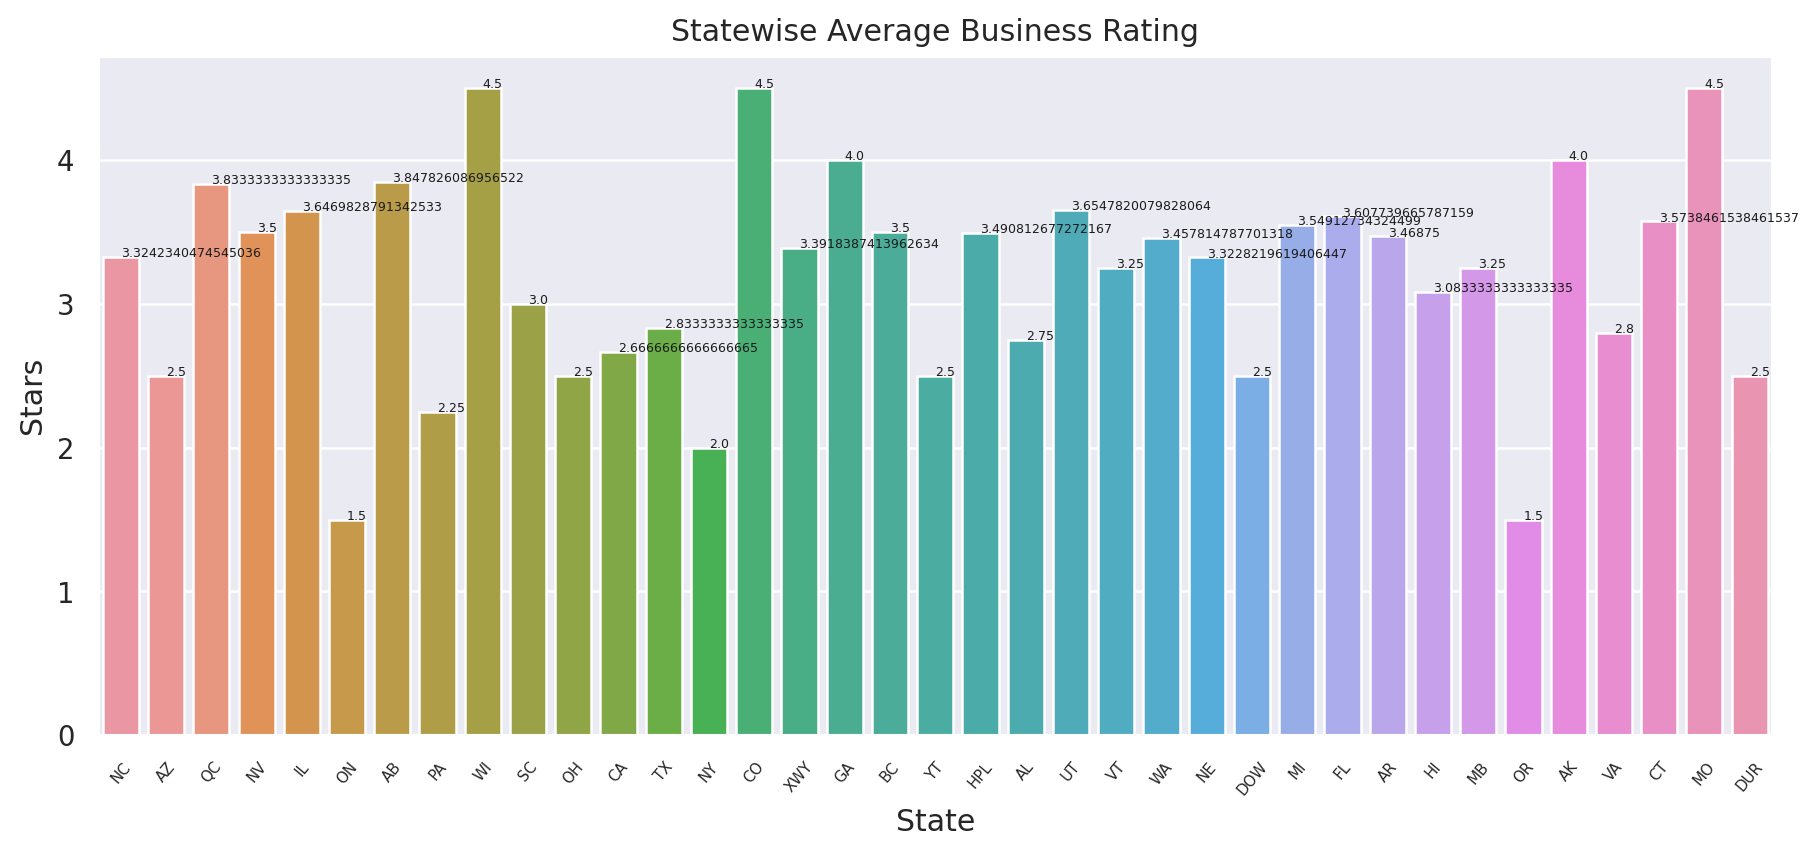

In [142]:
sns.set()
sns.despine()
plt.figure(dpi=180)

ax = sns.barplot(x="State", y="Stars", data=d)
ax.set_title('Statewise Average Business Rating')
ax.set_xticklabels(d.State,rotation=50,size=6)

for i, v in enumerate(d["Stars"].iteritems()):        
    ax.text(i ,v[1], "{:,}".format(v[1]), color='k',size=5)

# 5 Bunisess response to Covid

<a id ='covid'></a>

## 5.1 Donout Chart

In [40]:
#reading  covid data
covid_data = pd.read_csv('/home/jasp/sem_3/cpsc/project/yelp_dataset/code/covid_data_only_for_aditi.csv',
                  usecols = lambda column : column not in ["Unnamed: 0" ])

In [42]:
# Data Wrangling 

my_covid_data = covid_data[['state','delivery or takeout','Grubhub enabled','Call To Action enabled','Request a Quote Enabled']]

In [43]:
my_covid_data['delivery or takeout'] = my_covid_data['delivery or takeout'].astype(int)
my_covid_data['Grubhub enabled'] = my_covid_data['Grubhub enabled'].astype(int)
my_covid_data['Call To Action enabled'] = my_covid_data['Call To Action enabled'].astype(int)
my_covid_data['Request a Quote Enabled'] = my_covid_data['Request a Quote Enabled'].astype(int)

/home/jasp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/jasp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/jasp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

In [56]:
input_covid_data = my_covid_data.groupby('state').count()

In [58]:
# Adding Angle Value and Color 
input_covid_data['angle'] = input_covid_data['delivery or takeout']/input_covid_data['delivery or takeout'].sum() * 2*pi
input_covid_data['value']=110*(input_covid_data['delivery or takeout']/input_covid_data['delivery or takeout'].sum())
input_covid_data = input_covid_data.sort_values(by=['value'], ascending=False).head(10).reset_index()
input_covid_data['color'] = Category20c[10]


input_covid_data['state'] = input_covid_data['state'].map(mapping)

input_covid_data.head()



,state,delivery or takeout,Grubhub enabled,Call To Action enabled,Request a Quote Enabled,angle,value,color
0,"Arizona,US",60987,60987,60987,60987,1.838957,32.194697,#3182bd
1,"Nevada,US",39196,39196,39196,39196,1.181887,20.691350,#6baed6
2,"Ontario, CA",36639,36639,36639,36639,1.104785,19.341524,#9ecae1
3,"Ohio, US",16402,16402,16402,16402,0.494574,8.658524,#c6dbef
4,"North Carolina, US",16273,16273,16273,16273,0.490684,8.590426,#e6550d


In [59]:
p = figure(plot_height=450,
           plot_width = 750,
           title="Delievry and Take Away Started", 
           toolbar_location=None,
           tools="hover", 
           tooltips="@state: @value{0.2f} %", x_range=(-.5, .5))

p.annular_wedge(x=0, y=1,
                inner_radius=0.15, 
                outer_radius=0.25, 
                direction="anticlock",
                start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
                line_color="white", 
                fill_color='color',
                legend='state',
                source=input_covid_data)


p.axis.axis_label=None
p.axis.visible=False
p.grid.grid_line_color = None


show(p)

## 5.2 Bubble Chart

In [92]:
# merging business and covid
business_in_covid = business.merge(covid_data, how='right', on='business_id')

In [93]:
business_in_covid['delivery or takeout']

0         False
1         False
2         False
3         False
4         False
          ...  
209790     True
209791    False
209792     True
209793    False
209794    False
Name: delivery or takeout, Length: 209795, dtype: bool

numpy.bool_

In [98]:
business_in_covid.head()

,business_id,name_x,address,city_x,state_x,postal_code,latitude,longitude,stars,review_count,...,state_y,city_y,highlights,delivery or takeout,Grubhub enabled,Call To Action enabled,Request a Quote Enabled,Covid Banner,Temporary Closed Until,Virtual Services Offered
0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,10913 Bailey Rd,Cornelius,NC,28031,35.462724,-80.852612,3.5,36,...,NC,Cornelius,FALSE,False,False,False,False,FALSE,FALSE,FALSE
1,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD","8880 E Via Linda, Ste 107",Scottsdale,AZ,85258,33.569404,-111.890264,5.0,4,...,AZ,Scottsdale,FALSE,False,False,False,False,FALSE,FALSE,FALSE
2,XNoUzKckATkOD1hP6vghZg,Felinus,3554 Rue Notre-Dame O,Montreal,QC,H4C 1P4,45.479984,-73.580070,5.0,5,...,QC,Montreal,FALSE,False,False,False,False,FALSE,FALSE,FALSE
3,6OAZjbxqM5ol29BuHsil3w,Nevada House of Hose,1015 Sharp Cir,North Las Vegas,NV,89030,36.219728,-115.127725,2.5,3,...,NV,North Las Vegas,FALSE,False,False,False,False,FALSE,FALSE,FALSE
4,51M2Kk903DFYI6gnB5I6SQ,USE MY GUY SERVICES LLC,4827 E Downing Cir,Mesa,AZ,85205,33.428065,-111.726648,4.5,26,...,AZ,Mesa,FALSE,False,False,True,False,The team at Use My Guy Services are taking saf...,FALSE,FALSE


In [109]:
grouped_data_stars = business_in_covid[['stars','delivery or takeout']].groupby('stars').count().reset_index()

In [105]:
grouped_data_stars.head()

,stars,delivery or takeout
0,1.0,5918
1,1.5,6034
2,2.0,13163
3,2.5,21492
4,3.0,28679


In [107]:


df = px.data.gapminder()

fig = px.scatter(grouped_data_stars, 
                 x=grouped_data_stars.stars,
                 size="delivery or takeout", 
                 color=grouped_data_stars["delivery or takeout"],
                 log_x=True, size_max=80)


fig.update_layout(
    title='Take out & Delievery vs Rating',
    xaxis=dict(
        title='Ratings',
        gridcolor='white',
        type='log',
        gridwidth=2,
    ),
    yaxis=dict(
        title='',
        gridcolor='white',
        gridwidth=2,
    ),
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
)



fig.show()


## 5.3 Stacked Bar Chart

In [111]:
grouped_data_stars.head()

,stars,delivery or takeout
0,1.0,5918
1,1.5,6034
2,2.0,13163
3,2.5,21492
4,3.0,28679


In [118]:
data_bar_chart =  covid_data.groupby('state').sum().reset_index()
my_data_bar_chart = pd.melt(data_bar_chart,id_vars=['state'],value_vars=['delivery or takeout','Grubhub enabled','Call To Action enabled','Request a Quote Enabled'])
my_data_bar_chart = my_data_bar_chart[my_data_bar_chart.value > 10]
my_data_bar_chart.head()

,state,variable,value
0,AB,delivery or takeout,3186.0
4,AZ,delivery or takeout,13643.0
15,IL,delivery or takeout,744.0
19,NC,delivery or takeout,5247.0
21,NV,delivery or takeout,8993.0


In [117]:

alt.Chart(my_data_bar_chart).mark_bar().encode(
    x='state',
    y='sum(value)',
    color='variable',
    
    tooltip = [alt.Tooltip('value:Q'),
               alt.Tooltip('state:N')]
    
)

alt.Chart(...)

# 6  4 D graph

<a id = "graph"></a>

In [120]:
#loading check in object 
check_in = pd.read_json("/home/jasp/sem_3/cpsc/project/yelp_dataset/data/yelp_academic_dataset_checkin.json", lines=True)

In [121]:
#merging business and check in object
business_check_in = business.merge(check_in, left_on='business_id', right_on='business_id')

In [122]:
Starbucks_check_in_data = business_check_in[business_check_in['name'].str.match('Starbucks')]

In [123]:
def analysis(business_city):

    
    weekdays_for_check_in =[]
    for x in Starbucks_check_in_data[Starbucks_check_in_data['city'].str.match(business_city)].date:
        all_dates=x.split(",")
        for dates in all_dates:
            weekdays_for_check_in.append(pd.to_datetime(dates).weekday())
    

    monday_for_check_in = 0 
    tuesday_for_check_in =0
    wednesday_for_check_in =0
    thrusday_for_check_in =0
    friday_for_check_in =0
    saturday_for_check_in =0
    sunday_for_check_in =0
    
    
    
    for day_of_week in weekdays_for_check_in:
        if day_of_week == 0:
            monday_for_check_in+=1
        elif day_of_week ==1:
            tuesday_for_check_in+=1
        elif day_of_week ==2:
            wednesday_for_check_in+=1
        elif day_of_week == 3:
            thrusday_for_check_in+=1
        elif day_of_week == 4:
            friday_for_check_in+=1
        elif day_of_week == 5:
            saturday_for_check_in+=1
        elif day_of_week == 6:
            sunday_for_check_in+=1
            
            
    

    check_in_source = pd.DataFrame({'Day': ['Monday', 'Tuesday', 'Wednesday', 'Thrusday', 'Friday','Saturday','Sunday'],
                                   'check_in_count': [monday_for_check_in, tuesday_for_check_in, wednesday_for_check_in, thrusday_for_check_in, friday_for_check_in,saturday_for_check_in,sunday_for_check_in]})

    
    
    
    
    weekdays_for_review_count=[]
    
    
    monday_for_review_count = 0
    tuesday_for_review_count = 0
    wednesday_for_review_count = 0
    thrusday_for_review_count = 0
    friday_for_review_count = 0
    saturday_for_review_count = 0
    sunday_for_review_count = 0



    for date in review_updated[review_updated['business_id'].isin(Starbucks_check_in_data[Starbucks_check_in_data['city'].str.match(business_city)].business_id)].date:
        weekdays_for_review_count.append(pd.to_datetime(date).weekday())


    for day_of_week in weekdays_for_review_count:
        if day_of_week == 0:
            monday_for_review_count+=1
        elif day_of_week ==1:
            tuesday_for_review_count+=1
        elif day_of_week ==2:
            wednesday_for_review_count+=1
        elif day_of_week == 3:
            thrusday_for_review_count+=1
        elif day_of_week == 4:
            friday_for_review_count+=1
        elif day_of_week == 5:
            saturday_for_review_count+=1
        elif day_of_week == 6:
            sunday_for_review_count+=1   
            
            
    
    review_source = pd.DataFrame({'Day': ['Monday', 'Tuesday', 'Wednesday', 'Thrusday', 'Friday','Saturday','Sunday'],
                               'review_count': [monday_for_review_count, tuesday_for_review_count, wednesday_for_review_count, thrusday_for_review_count, friday_for_review_count,saturday_for_review_count,sunday_for_review_count]})

    
    
    
    
    check_in = alt.Chart(check_in_source).mark_bar(color='royalblue').encode(
                   x=alt.X('Day:N', axis=alt.Axis( title='Day'),sort=['Monday','Tuesday','Wednesday','Thrusday','Friday','Saturday','Sunday']),
                   y=alt.Y('check_in_count:Q', axis=alt.Axis( title='Total Check_in'))
                    ).interactive()

    time_of_review = alt.Chart(review_source).encode(

         x=alt.X('Day:N', 
                axis=alt.Axis( title='Day'),
               sort=['Monday','Tuesday','Wednesday','Thrusday','Friday','Saturday','Sunday']),
        y=alt.Y('review_count:Q', axis=alt.Axis( title='Total Reviews'))
        )

    temp = time_of_review.mark_line(color='green') + time_of_review.mark_point(color='black', filled = True)


    final_plot = (check_in + temp).resolve_scale(y='independent').configure_axis(grid=True).properties(
                                                                                                        width=700,
                                                                                                        height=600
        ,
                                                                                                        title='City Wise Analysis Of Starbucks'
                                                                                                    ).configure_point(size = 400)
    return final_plot

In [124]:
options = [('Montréal', 'Montréal'),
 ('Phoenix', 'Phoenix'),
 ('Las Vegas', 'Las Vegas'),
 ('Mississauga', 'Mississauga'),
 ('Cleveland', 'Cleveland'),
 ('Charlotte', 'Charlotte'),
 ('North Las Vegas', 'North Las Vegas'),
 ('Beachwood', 'Beachwood'),
 ('Willoughby', 'Willoughby'),
 ('Calgary', 'Calgary'),
 ('Markham', 'Markham'),
 ('Toronto', 'Toronto'),
 ('Peoria', 'Peoria'),
 ('Mesa', 'Mesa'),
 ('Pittsburgh', 'Pittsburgh'),
 ('Brampton', 'Brampton'),
 ('Saint-Sauveur', 'Saint-Sauveur'),
 ('Tempe', 'Tempe'),
 ('Chargrin Falls', 'Chargrin Falls'),
 ('Carefree', 'Carefree'),
 ('Gilbert', 'Gilbert'),
 ('Henderson', 'Henderson'),
 ('North York', 'North York'),
 ('Aurora', 'Aurora'),
 ('Thornhill', 'Thornhill'),
 ('Wexford', 'Wexford'),
 ('Surprise', 'Surprise'),
 ('Westlake', 'Westlake'),
 ('Monroe', 'Monroe'),
 ('Scottsdale', 'Scottsdale'),
 ('Akron', 'Akron'),
 ('Chandler', 'Chandler'),
 ('Cuyahoga Falls', 'Cuyahoga Falls'),
 ('Mont-Royal', 'Mont-Royal'),
 ('Solon', 'Solon'),
 ('Rocky View', 'Rocky View'),
 ('Bethel Park', 'Bethel Park'),
 ('Bradford West Gwillimbury', 'Bradford West Gwillimbury'),
 ('Concord', 'Concord'),
 ('Scarborough', 'Scarborough'),
 ('Parma', 'Parma'),
 ('Fort Mill', 'Fort Mill'),
 ('Berea', 'Berea'),
 ('Fountain Hills', 'Fountain Hills'),
 ('Glendale', 'Glendale'),
 ('Madison', 'Madison'),
 ('Ajax', 'Ajax'),
 ('Brunswick', 'Brunswick'),
 ('Avondale', 'Avondale'),
 ('Cornelius', 'Cornelius'),
 ('Tolleson', 'Tolleson'),
 ('Laval', 'Laval'),
 ('Champaign', 'Champaign'),
 ('Richmond Hill', 'Richmond Hill'),
 ('Cave Creek', 'Cave Creek'),
 ('Avon', 'Avon'),
 ('Bridgeville', 'Bridgeville'),
 ('Sun City West', 'Sun City West'),
 ('Whitby', 'Whitby'),
 ('Amherst', 'Amherst'),
 ('Oakville', 'Oakville'),
 ('Streetsboro', 'Streetsboro'),
 ('Milton', 'Milton'),
 ('Mentor', 'Mentor'),
 ('Kent', 'Kent'),
 ('Urbana', 'Urbana'),
 ('Gastonia', 'Gastonia'),
 ('West Homestead', 'West Homestead'),
 ('Independence', 'Independence'),
 ('Broadview Heights', 'Broadview Heights'),
 ('Vaughan', 'Vaughan'),
 ('N Las Vegas', 'N Las Vegas'),
 ('Pointe-Claire', 'Pointe-Claire'),
 ('Murrysville', 'Murrysville'),
 ('Indian Land', 'Indian Land'),
 ('Canonsburg', 'Canonsburg'),
 ('Vaudreuil-Dorion', 'Vaudreuil-Dorion'),
 ('Middleton', 'Middleton'),
 ('Mayfield Heights', 'Mayfield Heights'),
 ('Allison Park', 'Allison Park'),
 ('Airdrie', 'Airdrie'),
 ('Lorain', 'Lorain'),
 ('Goodyear', 'Goodyear'),
 ('Northfield', 'Northfield'),
 ('Sun City', 'Sun City'),
 ('Hudson', 'Hudson'),
 ('North Charlotte', 'North Charlotte'),
 ('Dallas', 'Dallas'),
 ('Fairview Park', 'Fairview Park'),
 ('Harrisburg', 'Harrisburg'),
 ('Matthews', 'Matthews'),
 ('Lakewood', 'Lakewood'),
 ('Stow', 'Stow'),
 ('Maple', 'Maple'),
 ('Litchfield Park', 'Litchfield Park'),
 ('Pittsburg', 'Pittsburg'),
 ('Huntersville', 'Huntersville'),
 ('Medina', 'Medina'),
 ('Strongsville', 'Strongsville'),
 ('Caledon', 'Caledon'),
 ('North Olmsted', 'North Olmsted'),
 ('Moon Township', 'Moon Township'),
 ('Woodbridge', 'Woodbridge'),
 ('Kirkland', 'Kirkland'),
 ('Newmarket', 'Newmarket'),
 ('Boulder City', 'Boulder City'),
 ('McMurray', 'McMurray'),
 ("L'Île-Perrot", "L'Île-Perrot"),
 ('Gibsonia', 'Gibsonia'),
 ('Franklin Park', 'Franklin Park'),
 ('Tarentum', 'Tarentum'),
 ('Whitchurch-Stouffville', 'Whitchurch-Stouffville'),
 ('Indian Trail', 'Indian Trail'),
 ('Garfield Heights', 'Garfield Heights'),
 ('Fitchburg', 'Fitchburg'),
 ('Cleveland Heights', 'Cleveland Heights'),
 ('Macedonia', 'Macedonia'),
 ('Rocky River', 'Rocky River'),
 ('Woodmere', 'Woodmere'),
 ('Monona', 'Monona'),
 ('Lyndhurst', 'Lyndhurst'),
 ('Rock Hill', 'Rock Hill'),
 ('Laveen', 'Laveen'),
 ('Brooklyn', 'Brooklyn'),
 ('Queen Creek', 'Queen Creek'),
 ('Sheffield Village', 'Sheffield Village'),
 ('Unionville', 'Unionville'),
 ('South Euclid', 'South Euclid'),
 ('Sewickley', 'Sewickley'),
 ('Anthem', 'Anthem'),
 ('Pleasant Hills', 'Pleasant Hills'),
 ('La Salle', 'La Salle'),
 ('Rosemère', 'Rosemère'),
 ('Nellis Afb', 'Nellis Afb'),
 ('Pineville', 'Pineville'),
 ('Verona', 'Verona'),
 ('Pickering', 'Pickering'),
 ('Chestermere', 'Chestermere'),
 ('CLEVELAND', 'CLEVELAND'),
 ('Westmount', 'Westmount'),
 ('Waxhaw', 'Waxhaw'),
 ('Sun Prairie', 'Sun Prairie'),
 ('Monroeville', 'Monroeville'),
 ('Delson', 'Delson'),
 ('Twinsburg', 'Twinsburg'),
 ('Saint-Laurent', 'Saint-Laurent'),
 ('Etobicoke', 'Etobicoke'),
 ('Mascouche', 'Mascouche'),
 ('Halton Hills', 'Halton Hills'),
 ('Dollard-des-Ormeaux', 'Dollard-des-Ormeaux'),
 ('Belmont', 'Belmont'),
 ('Brecksville', 'Brecksville'),
 ('East York', 'East York'),
 ('Buckeye', 'Buckeye'),
 ('Brossard', 'Brossard')]


interact(analysis, business_city=options)

interactive(children=(Dropdown(description='business_city', options=(('Montréal', 'Montréal'), ('Phoenix', 'Ph…

<function __main__.analysis(business_city)>

# 7 Pie Chart
<a id ='pie'></a>

In [165]:
temp_categories = business.categories
temp_categories.dropna(inplace=True)

In [166]:
Categories={}
for i in temp_categories:
    all_categories=i.split(",")
    for cat in all_categories:
        if cat not in Categories:
            Categories[cat]=1
        else:
            Categories[cat]+=1

In [167]:
do=pd.DataFrame.from_dict(Categories,orient='index')
do.reset_index(inplace=True)
d2 = {'index': 'Categories', 0: 'Count'}
do.rename(columns=d2,inplace=True)
top_business=do.sort_values(by=['Count'],ascending=False).head(25)

In [168]:

fig = px.pie(top_business, values='Count', names='Categories', title='Top Business on YELP')

fig.show()


In [2]:
import anvil.server
anvil.server.connect('4MTNZV6V6WN3IOTZXM4NHGJD-56XDRTYIQGTGQJY4')

Connecting to wss://anvil.works/uplink
Anvil websocket open
Authenticated OK
Anvil websocket closed (code 1006, reason=Going away)


Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/jasp/anaconda3/lib/python3.7/site-packages/anvil/server.py", line 286, in call
    return _do_call(args, kwargs, fn_name=fn_name)
  File "/home/jasp/anaconda3/lib/python3.7/site-packages/anvil/server.py", line 278, in _do_call
    return _threaded_server.do_call(args, kwargs, fn_name=fn_name, live_object=live_object)
  File "/home/jasp/anaconda3/lib/python3.7/site-packages/anvil/_threaded_server.py", line 402, in do_call
    raise _server._deserialise_exception(r["error"])
anvil._server.AnvilWrappedError: 'Connection to Anvil Uplink server lost'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jasp/anaconda3/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/home/jasp/anaconda3/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jasp/anaconda3/lib/python3

Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Anvil websocket open
Authenticated OK
